In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from scipy.integrate import solve_ivp

In [2]:
#A1 Parameters for A1
D1 = 0.1
D2 = 0.1
beta = 1
n = 64
T = 4
tspan = np.arange(0,4.5,0.5) 
Lx, Ly = 20, 20 
nu = 0.001
nx, ny = 64, 64 
N = nx * ny

In [3]:
# define the spatial domain 
x2 = np.linspace(-Lx/2, Lx/2, nx+1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny+1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

In [4]:
# K values 
kx = (2 * np.pi /(Lx)) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi /(Ly)) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

In [5]:
# compute u and v 
m = 1
u = np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)))
v = np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)))
ut = fft2(u)
vt = fft2(v)
uvt0 = np.hstack([(ut.reshape(N)),(vt.reshape(N))])

In [6]:
# define PDE with FFT
def spectral_rhs(t,uvt, N, nx, ny, D1, D2, beta, K):
    utc = uvt[:N]
    vtc = uvt[N:]
    ut = utc.reshape((nx, ny))  # Reshape U
    vt = vtc.reshape((nx, ny))  # Reshape V
    u = ifft2(ut)
    v = ifft2(vt)
    A2 = u**2 + v**2
    lam = 1 - A2
    ome = -beta * A2
    rhs_u = (-D1*K*ut + fft2(lam*u - ome*v)).reshape(N)
    rhs_v = (-D2*K*vt + fft2(ome*u + lam*v)).reshape(N)
    rhs = np.hstack([(rhs_u),(rhs_v)])
    return rhs

In [7]:
#solve_ivp stepping 
uvtsol = solve_ivp(spectral_rhs, [0,T], uvt0, 
                   t_eval = tspan, args = (N, nx, ny, D1, D2, beta, K),method = "RK45")
z = uvtsol.y
A1 = z

In [8]:
A1

array([[ 24.94003847+0.00000000e+00j,  12.73268299-1.77125155e-15j,
         -1.38095598-6.04759423e-15j, ..., -64.02389647+3.96087485e-16j,
        -67.76356741+4.06961411e-15j, -61.18058974+1.78026568e-14j],
       [-18.55666362-5.81663109e+01j, -42.51586944-4.69129224e+01j,
        -60.80795253-2.57480390e+01j, ..., -26.39439597+1.13082890e+02j,
          6.86544434+1.23000456e+02j,  41.4436393 +1.10055312e+02j],
       [-16.04755868+3.28279829e+01j, -22.03971648-4.57977740e+01j,
        -23.23089505-1.04141716e+02j, ..., -25.03391682-9.26527314e+01j,
        -29.2936105 -4.09594873e+01j, -31.3712619 +1.56986891e+01j],
       ...,
       [ 24.73021466-5.66774723e+02j,  34.94179045-3.31372917e+02j,
         38.82924248-4.97842318e+01j, ...,   4.99619196+6.02396295e+02j,
         -9.93322885+4.90736906e+02j, -25.6299042 +2.81792021e+02j],
       [ 25.33720124-3.61633792e+02j,  43.00958768-4.53711746e+02j,
         51.93221654-4.47841562e+02j, ..., -30.76392977+2.66442187e+02j,
       

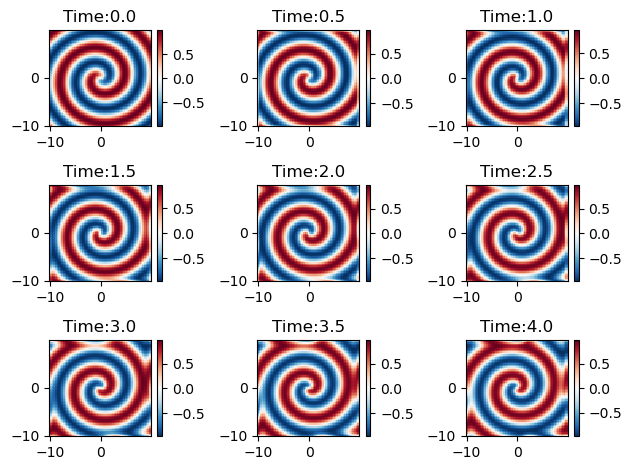

In [9]:
for j, t in enumerate(tspan):
    u = np.real(ifft2(z[N:,j].reshape((nx,ny))))
    plt.subplot(3,3,j+1)
    plt.pcolor(x,y,u,cmap = 'RdBu_r')
    plt.title(f'Time:{t}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [10]:
# Function for Chebyshev points
def cheb(N):
    if N == 0:
        D = 0.
        x = 1.
    else:
        n = np.arange(0, N+1)
        x = np.cos(np.pi * n / N).reshape(N+1, 1)  # Chebyshev points
        c = (np.hstack(([2.], np.ones(N-1), [2.])) * (-1)**n).reshape(N+1, 1)  # Scaling factors
        X = np.tile(x, (1, N+1))
        dX = X - X.T
        D = np.dot(c, 1. / c.T) / (dX + np.eye(N+1))  # Off-diagonal terms
        D -= np.diag(np.sum(D.T, axis=0))  # Correct diagonal terms
    return D, x.reshape(N+1)

# Parameters
N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D) / ((20 / 2) ** 2)  # Second derivative matrix
y = x
N2 = (N+1) * (N+1)
I = np.eye(len(Dxx))
L = np.kron(I, Dxx) + np.kron(Dxx, I)  # 2D Laplacian

# Grid setup
X, Y = np.meshgrid(x, y)
X = X * (20 / 2)
Y = Y * (20 / 2)
m = 1  # Number of spirals
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2)))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2)))
uv0 = np.hstack([u.reshape(N2), v.reshape(N2)])

# Define function
def RD_2D(t, uv, N2, beta, D1, L, D2):
    u = uv[:N2]
    v = uv[N2:]
    A2 = u * u + v * v
    lam = 1 - A2
    ome = -beta * A2
    rhs_u = D1 * np.dot(L, u) + lam * u - ome * v
    rhs_v = D2 * np.dot(L, v) + ome * u + lam * v
    rhs = np.hstack([rhs_u, rhs_v])
    return rhs

# Solve system
uvsol = solve_ivp(RD_2D,[0, T],uv0,t_eval=tspan,args=(N2, beta, D1, L, D2),method="RK45")

# Solution
A2 = uvsol.y
print(A2)

[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


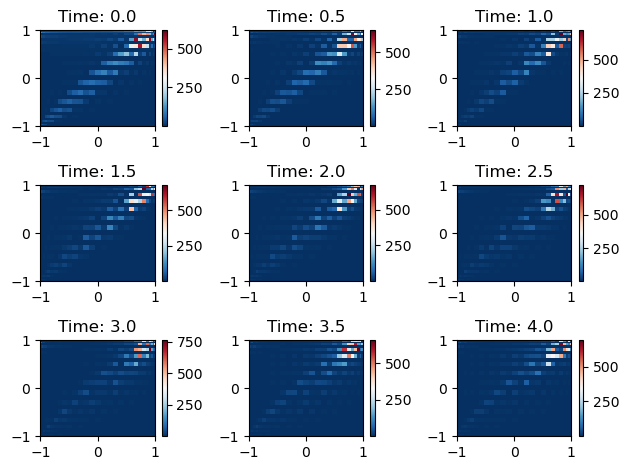

In [11]:
for j, t in enumerate(tspan):
    u = z[0:N2, j].reshape((N+1, N+1))
    u_real = np.abs(u)  # Take the magnitude of the complex numbers
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, u_real, cmap='RdBu_r')  # Use the real (magnitude) data
    plt.title(f'Time: {t}')
    plt.colorbar()
plt.tight_layout()
plt.show()